In [1]:
import jax.numpy as np
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

import lineax
import jax
import optax
import optimistix

from make_pulse_and_trace import MakePulse, apply_noise

from utilities import MyNamespace

In [2]:
pulse_maker=MakePulse(N=128*10, Deltaf=4) # Deltaf should be 3 for thg and 2 for shg -> depends on central_f is guess, currently 0.5
# ifrog -> Deltaf controls temporal resolution and needs to be sufficiently large 


pulse_maker.multi_pulse_time_domain_length_multiplier=8
pulse_maker.multi_pulse_parameters=[[50, 50], [5, 5, 5], [0.5, 0.25, 0.25], [1, 1, 1], ["flat", "flat", "flat"], [None, None, None]] 

time_inp, pulse_t_inp, frequency_inp, pulse_f_inp=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.3, 0.1], type="polynomial", parameters_phase=[1/4,0,0,1500,0], 
                                                                               multi_pulse_parameters=None)#pulse_maker.multi_pulse_parameters)

input_pulses=pulse_maker.input_pulses





time_gate, pulse_t_gate, frequency_gate, pulse_f_gate=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.45,0.05], type="polynomial", parameters_phase=[3/4,0,0,0], 
                                                                                   multi_pulse_parameters=None)

input_pulses_gate=pulse_maker.input_pulses

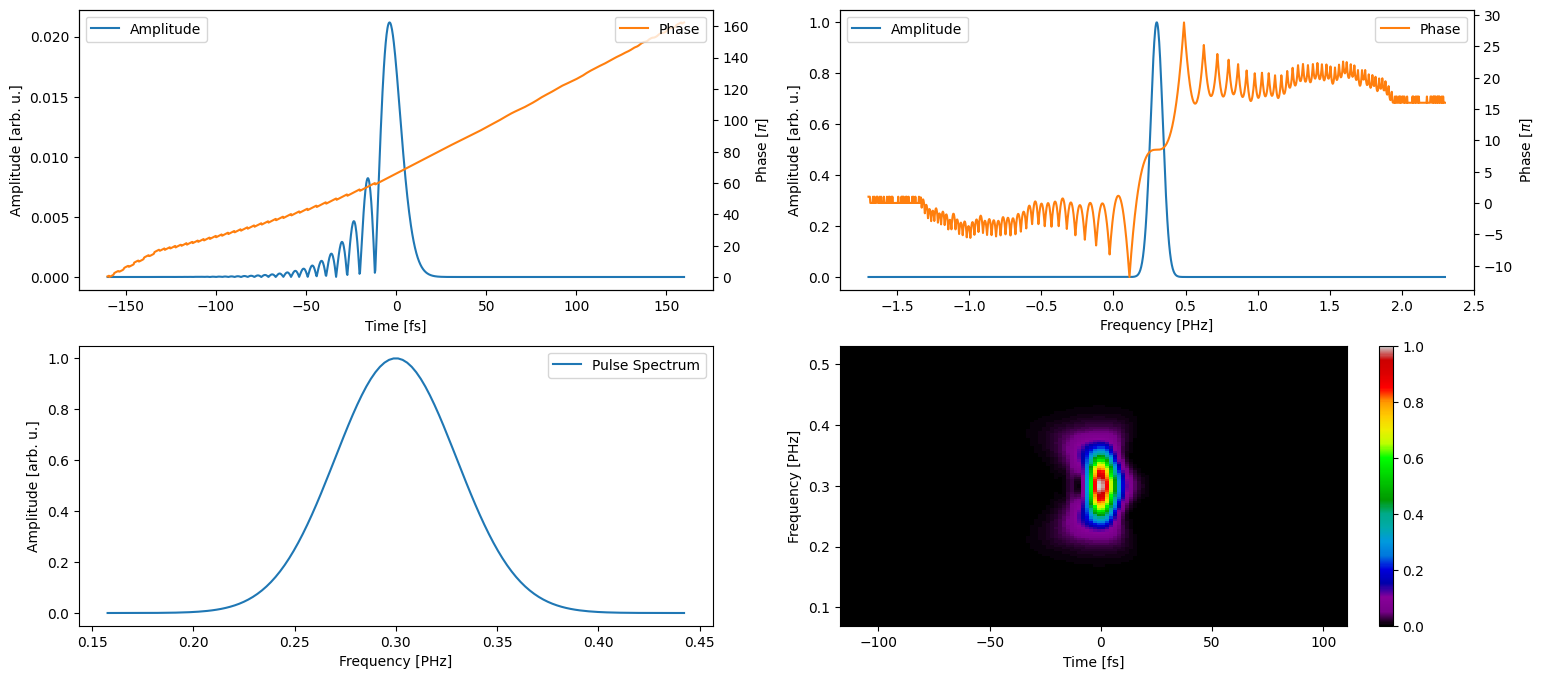

In [4]:
time, frequency, trace, spectra=pulse_maker.generate_frog_trace_and_spectrum(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, nonlinear_method="pg", 
                                                                                                  scale_time_range=5, N=128, xfrog=False, 
                                                                                                  gate=(frequency_gate, pulse_f_gate),
                                                                                                  interpolate_fft_conform=False, cut_off_val=1e-2,
                                                                                                  ifrog=False)#, frequency_range=(0,1))

#trace = apply_noise(trace, scale_val=(0.05, 0.05), additive_noise=True, multiplicative_noise=True)

/home/tillstehling/miniconda3/envs/optimistix_dev/lib/python3.12/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


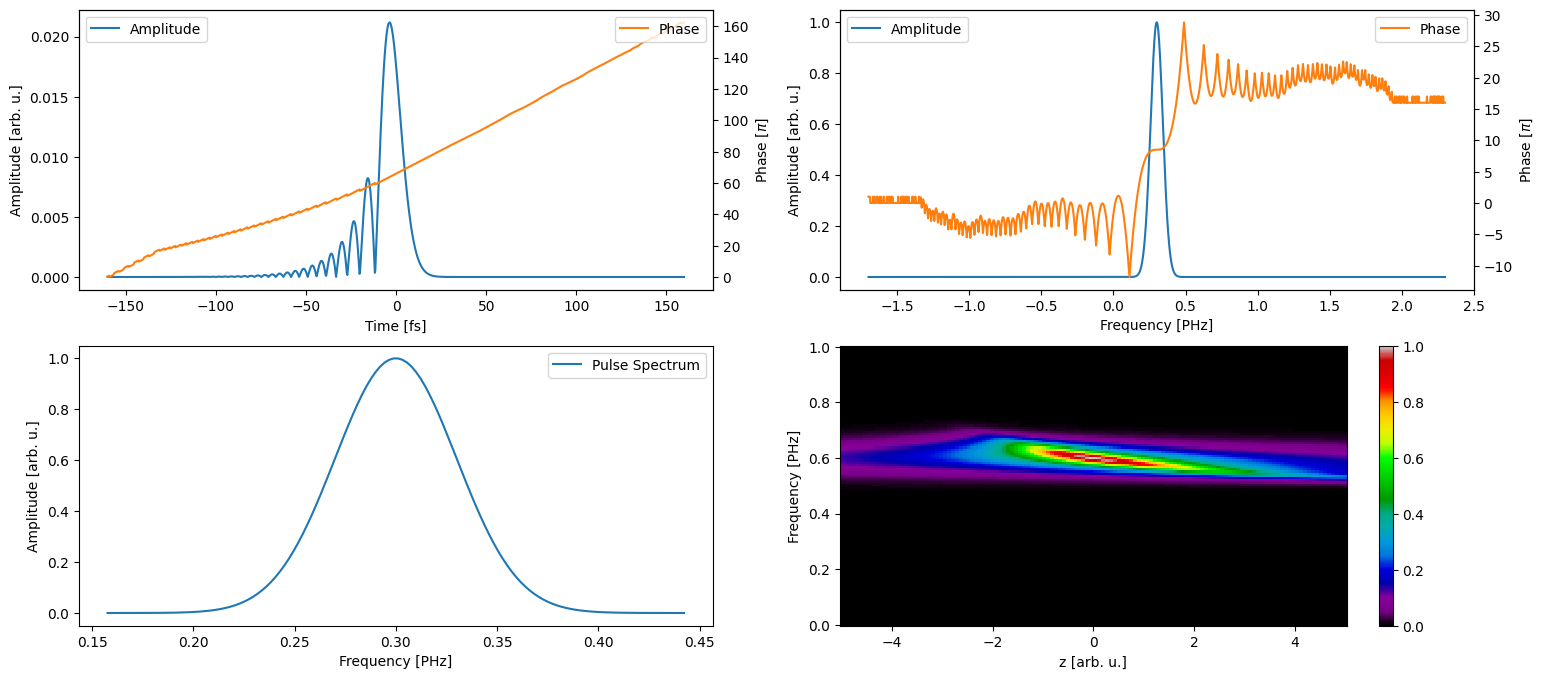

In [3]:
z_arr=np.linspace(-5, 5, 128)
#pulse_t, pulse_f=pulse_maker.precompensate_pulse_for_dscan(time, frequency, pulse_t, GDD=-5000, TOD=0, central_f=0.5)
frequency, trace, spectra = pulse_maker.generate_dscan_trace_and_spectrum(z_arr, time_inp, frequency_inp, pulse_t_inp, pulse_f_inp,
                                                                                                   nonlinear_method="shg", 
                                                                                                   N=128, cut_off_val=1e-3, frequency_range=(0,1))


#trace = apply_noise(trace, scale_val=0.01, additive_noise=True, multiplicative_noise=False)

# if there are weird stripes in the trace -> set Deltaf=2 somehow thats needed

In [5]:
from classic_algorithms_frog import Vanilla, LSGPA, GeneralizedProjection, TimeDomainPtychography, COPRA

(Array(0.9699753, dtype=float32), Array(-0.9699336, dtype=float32))
(Array(0.9694387, dtype=float32), Array(-0.9693717, dtype=float32))
(Array(0.9727179, dtype=float32), Array(-0.9726634, dtype=float32))
(Array(1.6804261e-08, dtype=float32), Array(-0.12549028, dtype=float32))
(Array(3.4258232e-08, dtype=float32), Array(-0.169936, dtype=float32))
(Array(2.512655e-08, dtype=float32), Array(-0.18520151, dtype=float32))
(Array(0.9699753, dtype=float32), Array(-0.9699718, dtype=float32))
(Array(0.9694387, dtype=float32), Array(-0.96943456, dtype=float32))
(Array(0.9727179, dtype=float32), Array(-0.9727142, dtype=float32))
(Array(4.102941e-10, dtype=float32), Array(-0.03619977, dtype=float32))
(Array(5.2545535e-10, dtype=float32), Array(-0.0419496, dtype=float32))
(Array(4.4205e-10, dtype=float32), Array(-0.04790043, dtype=float32))
(Array(0.96997535, dtype=float32), Array(-0.96997184, dtype=float32))
(Array(0.9694387, dtype=float32), Array(-0.96943456, dtype=float32))
(Array(0.9727178, dtyp

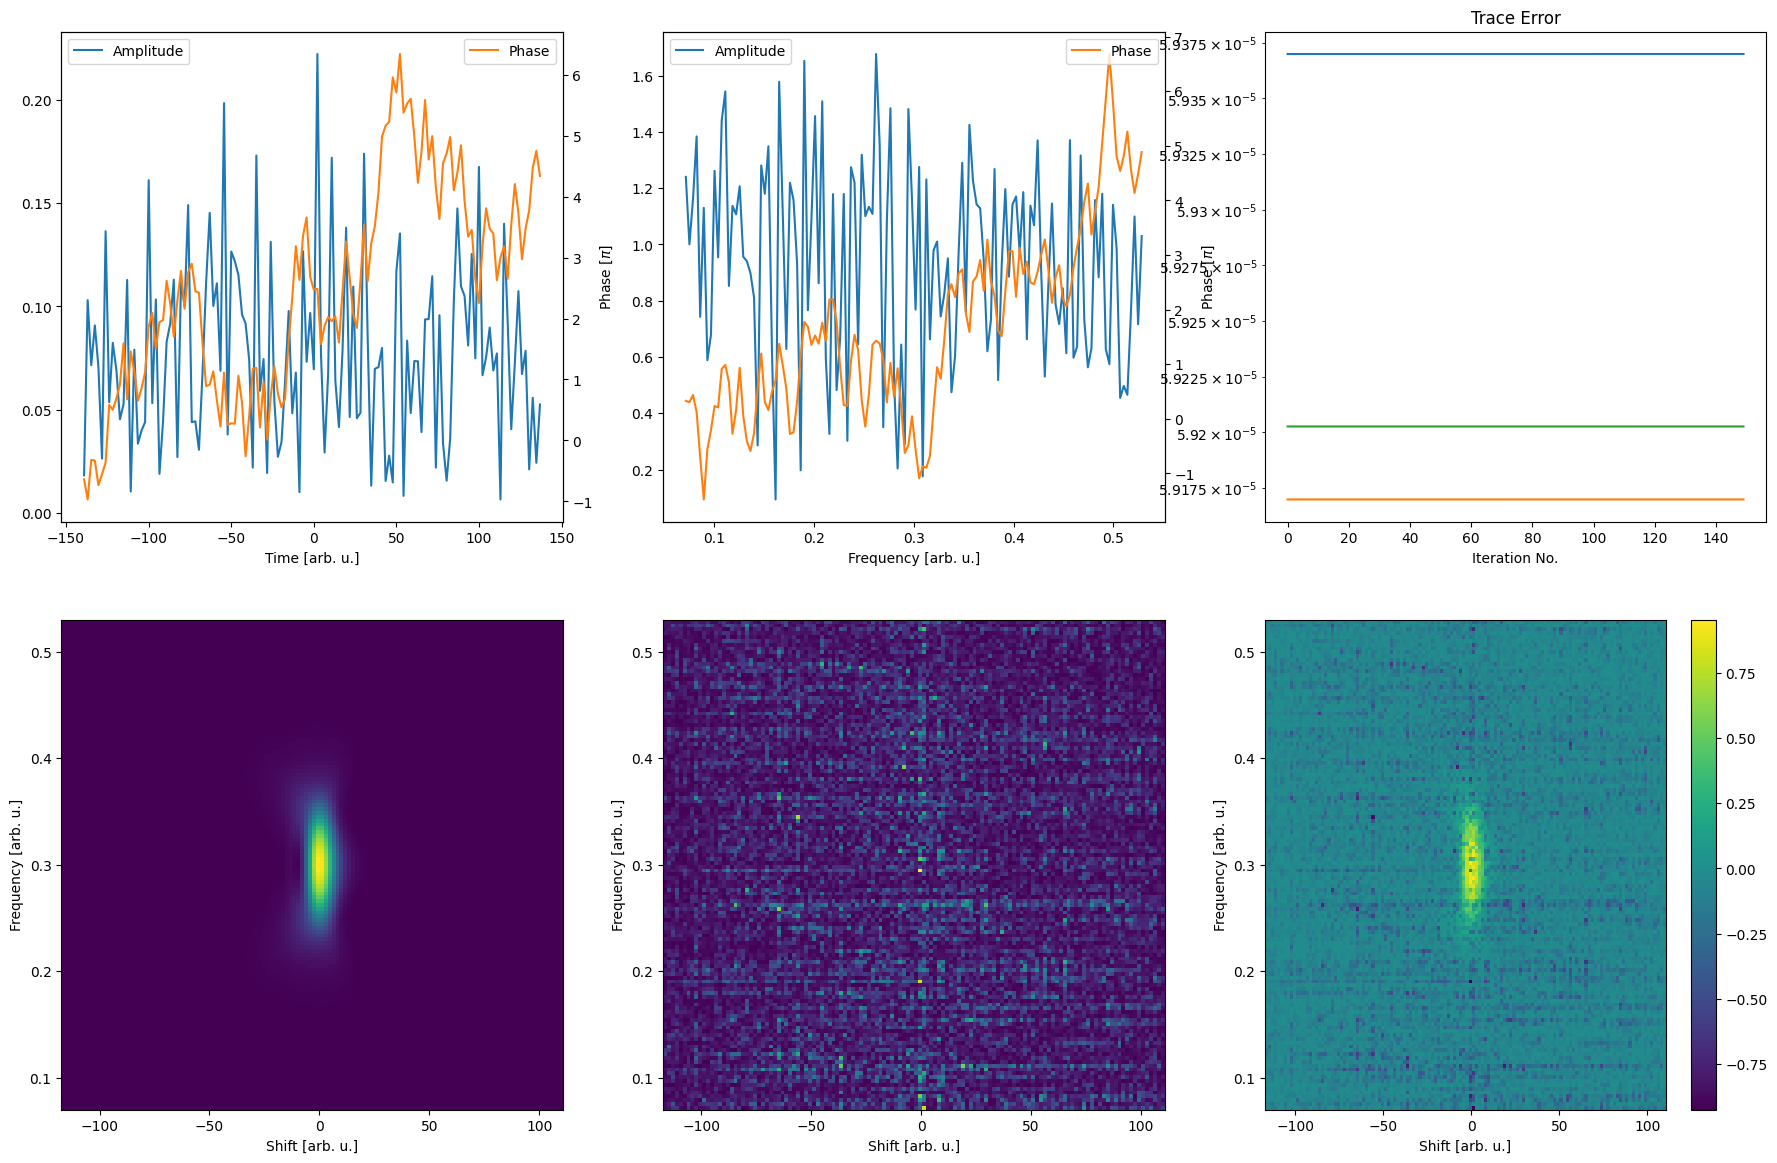

In [6]:
# vanilla = Vanilla(time, frequency, trace, "pg")
# population = vanilla.create_initial_population(population_size=3, guess_type="random")

# final_result = vanilla.run(population, 100)
# vanilla.plot_results(final_result)






# lsgpa = LSGPA(time, frequency, trace, "pg", xfrog=False)#.use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")
# population = lsgpa.create_initial_population(population_size=3, guess_type="random")

# final_result = lsgpa.run(population, 500)
# lsgpa.plot_results(final_result)






# gp = GeneralizedProjection(time, frequency, trace, "pg", xfrog="doubleblind")
# population = gp.create_initial_population(population_size=3, guess_type="random")

# gp.global_hessian = False#"diagonal"#"lbfgs"
# gp.use_conjugate_gradients=False


# # gp.no_steps_descent = 25
# # gp.max_steps_linesearch = 25
# gp.use_linesearch = "backtracking"
# gp.gamma = 1
# # gp.delta_gamma = (0.5, 1.1)
# # gp.c1 = 1e-4
# # gp.c2 = 0.9

# # gp.lbfgs_memory = 3

# # gp.use_copra_style_step_scaling = False


# final_result = gp.run(population, 15)
# gp.plot_results(final_result)






# tdp = TimeDomainPtychography(time, frequency, trace, "pg", "ePIE", xfrog="doubleblind")
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# tdp.alpha = 0.1
# tdp.local_gamma = 0.1
# tdp.global_gamma = 0.1

# tdp.lbfgs_memory = 15
# tdp.conjugate_gradients = False#"fletcher_reeves"

# tdp.global_hessian = False #"diagonal" #"lbfgs"
# tdp.use_linesearch = False #"wolfe"

# final_result = tdp.run(population, 15, 15)
# tdp.plot_results(final_result)





copra = COPRA(time, frequency, trace, "pg", ifrog=False)#, xfrog="doubleblind")
population = copra.create_initial_population(population_size=3, guess_type="random")

copra.use_linesearch = False #"wolfe"

copra.local_gamma=1
copra.global_gamma=0.25
copra.local_adaptive_scaling = "linear"
copra.global_adaptive_scaling = "nonlinear"
copra.xi=1e-12

copra.local_hessian=False
copra.global_hessian="diagonal"

final_result = copra.run(population, 0, 150)
copra.plot_results(final_result)



In [6]:
final_result.error_arr

Array([[5.9103055e-05, 5.8941107e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941107e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941107e-05, 5.9514223e-05],
       [5.9103051e-05, 5.8941107e-05, 5.9514223e-05],
       [5.9103055e-05, 5.8941114e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941107e-05, 5.9514223e-05],
       [5.9103051e-05, 5.8941107e-05, 5.9514223e-05],
       [5.9103055e-05, 5.8941107e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941107e-05, 5.9514223e-05],
       [5.9103051e-05, 5.8941114e-05, 5.9514223e-05],
       [5.9103055e-05, 5.8941114e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941114e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941114e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941114e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941107e-05, 5.9514226e-05],
       [5.9103051e-05, 5.8941114e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941114e-05, 5.9514226e-05],
       [5.9103055e-05, 5.8941114e-05, 5.9514226e-05],
       [5.9103051e-05, 5.894

In [8]:
from classic_algorithms_dscan import Basic, GeneralizedProjection, TimeDomainPtychography, COPRA

/home/tillstehling/miniconda3/envs/optimistix_dev/lib/python3.12/site-packages/refractiveindex/refractiveindex.py:297: RuntimeWarning: invalid value encountered in divide
  g = lambda c1, c2, w: c1 * (w ** 2) / (w ** 2 - c2 ** 2)
/home/tillstehling/miniconda3/envs/optimistix_dev/lib/python3.12/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


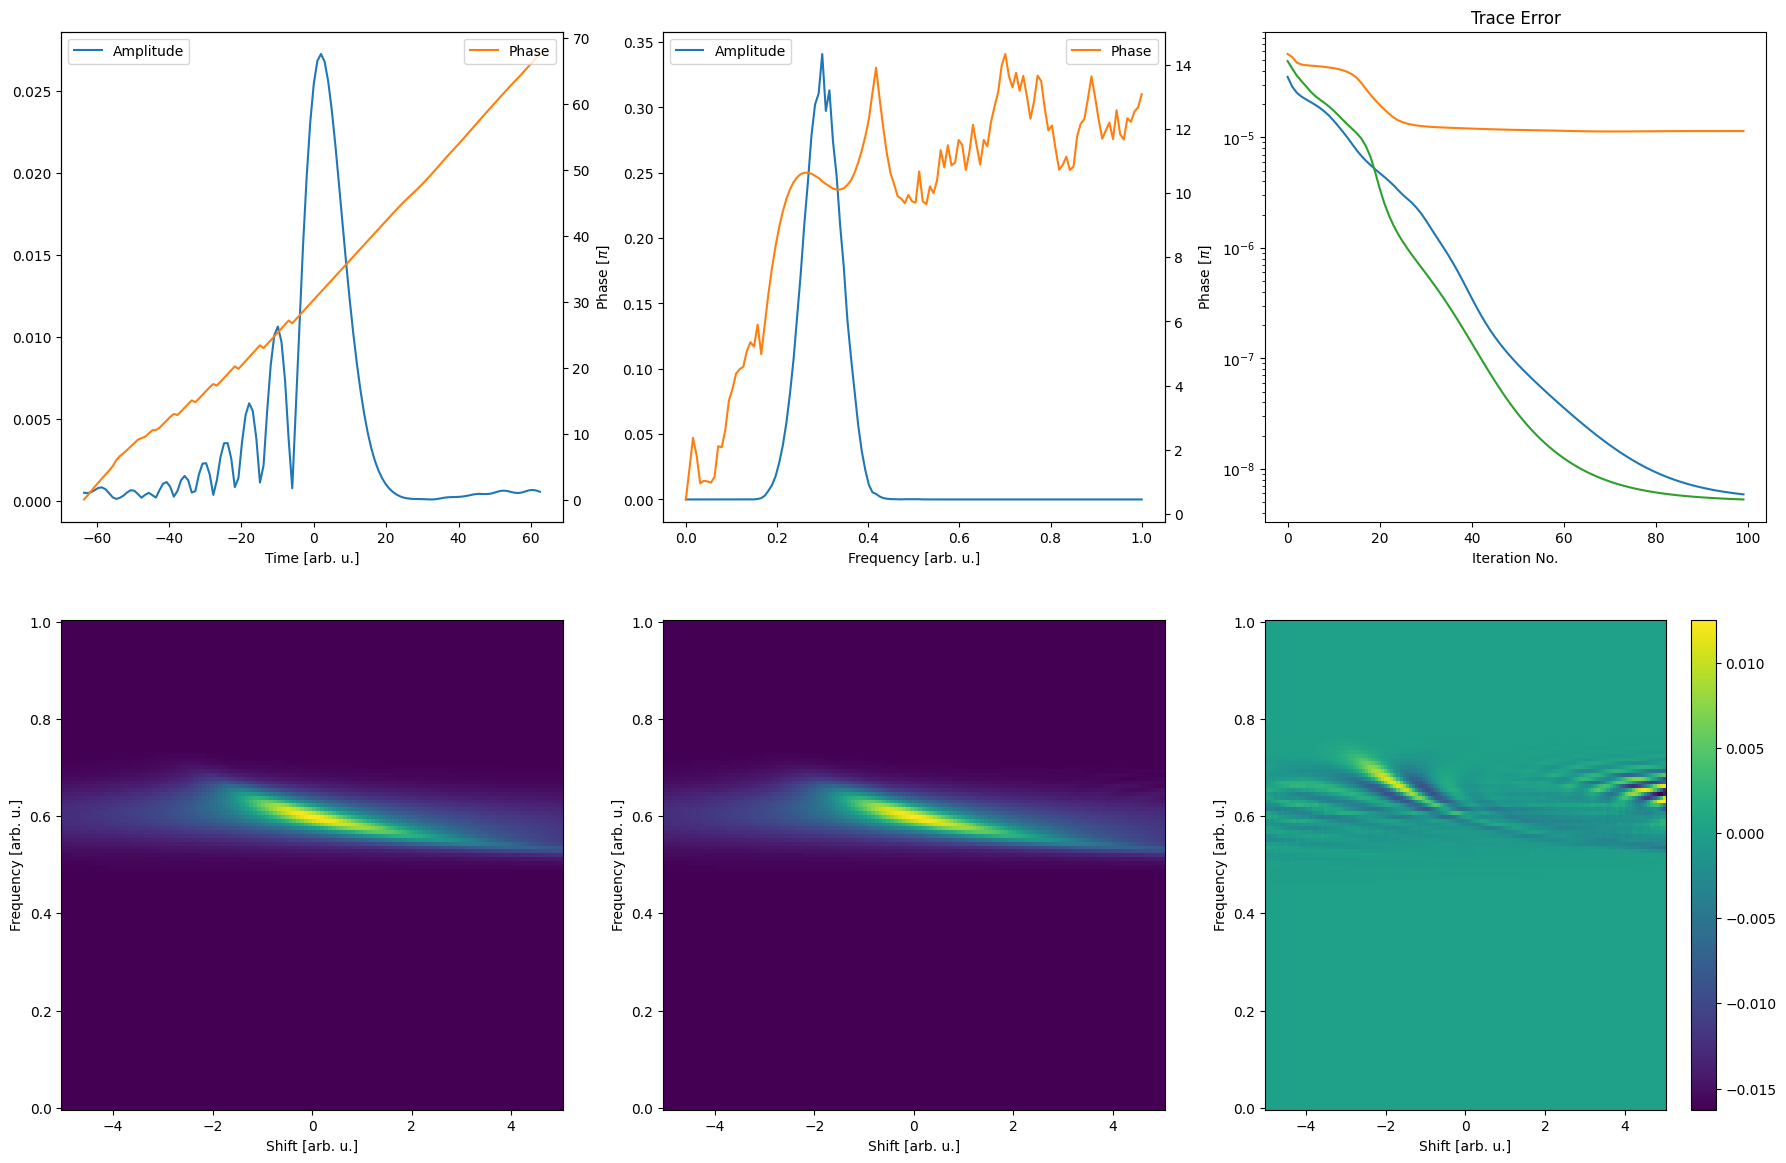

In [11]:
# basic = Basic(z_arr, frequency, trace, "shg")
# population = basic.create_initial_population(population_size=3, guess_type="random")

# final_result = basic.run(population, 100)
# basic.plot_results(final_result)





gp = GeneralizedProjection(z_arr, frequency, trace, "shg")
population = gp.create_initial_population(population_size=3, guess_type="random")

gp.global_hessian="lbfgs"#"diagonal"
gp.no_steps_descent=50
gp.gamma=1

final_result = gp.run(population, 100)
gp.plot_results(final_result)




# tdp = TimeDomainPtychography(z_arr, frequency, trace, "shg", pie_method="ePIE")
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# tdp.alpha=0.1
# tdp.local_gamma=0.005
# tdp.global_gamma=0.005

# tdp.use_linesearch=False
# tdp.global_hessian=False#"diagonal"

# final_result = tdp.run(population, 10, 10)
# tdp.plot_results(final_result)






# copra = COPRA(z_arr, frequency, trace, "shg")
# population = copra.create_initial_population(population_size=3, guess_type="random")

# copra.local_gamma = 1
# copra.global_gamma = 0.25

# copra.local_hessian = False
# copra.global_hessian = False

# copra.adaptive_scaling = "linear"

# final_result = copra.run(population, 12, 15)
# copra.plot_results(final_result)

In [ ]:
def one_local_iteration(self, signal_t, signal_t_new, transform_arr_m, descent_state, measurement_info, descent_info, pulse_or_gate):
        hessian = descent_info.hessian
        population = descent_state.population


        grad = self.calculate_Z_gradient(signal_t_new, signal_t, population, transform_arr_m, measurement_info, pulse_or_gate, local=True)
        
        if hessian.local_hessian!=False:
            descent_direction, hessian_state = self.calculate_Z_error_newton_direction(grad, signal_t_new, signal_t, transform_arr_m, descent_state, 
                                                                                       measurement_info, descent_info, hessian.local_hessian, 
                                                                                       pulse_or_gate, local=True)

            descent_state = tree_at(lambda x: getattr(x.local_state.hessian, pulse_or_gate), descent_state, hessian_state)
        else:
            descent_direction = -1*jnp.squeeze(grad)
            

        grad_norm2 = jnp.sum(jnp.abs(grad)**2)
        max_grad_norm2 = getattr(descent_state.local_state.max_grad_norm2, pulse_or_gate)
        max_grad_norm2 = jnp.greater(grad_norm2, max_grad_norm2)*grad_norm2 + jnp.greater(max_grad_norm2, grad_norm2)*max_grad_norm2

        descent_state = tree_at(lambda x: getattr(x.local_state.max_grad_norm2, pulse_or_gate), descent_state, max_grad_norm2)

        Z_error = jax.vmap(calculate_Z_error, in_axes=(0,0))(signal_t.signal_t, signal_t_new)
        gamma = Z_error/max_grad_norm2

        population = self.update_population_local(population, gamma, descent_direction, measurement_info, descent_info, pulse_or_gate)
        descent_state = tree_at(lambda x: x.population, descent_state, population)
        return  descent_state, Z_error
    

In [ ]:
def do_iteration(self, signal_t, signal_t_new, transform_arr, population, local_or_global_state, measurement_info, descent_info, 
                        pulse_or_gate, local_or_global):
    
    if local_or_global=="_global":
        shape = (descent_info.population_size, ) + jnp.shape(transform_arr)
        transform_arr = jnp.broadcast_to(transform_arr, shape)

    
    gamma, hessian_info = descent_info.gamma, getattr(descent_info.hessian, local_or_global)


    grad = self.calculate_Z_gradient(signal_t_new, signal_t, population, transform_arr, measurement_info, pulse_or_gate, local=False)
    grad_sum = jnp.sum(grad, axis=1)

    if hessian_info=="diagonal" or hessian_info=="full":
        descent_direction, hessian_state = self.calculate_Z_error_newton_direction(grad, signal_t_new, signal_t, transform_arr, descent_state, 
                                                                                    measurement_info, descent_info, hessian_info,
                                                                                    pulse_or_gate, local=False)

        local_or_global_state = tree_at(lambda x: getattr(x.global_state.hessian, pulse_or_gate), local_or_global_state, hessian_state)

    elif hessian_info=="lbfgs":
            lbfgs_state = getattr(local_or_global_state.lbfgs, pulse_or_gate)
            descent_direction, lbfgs_state = get_quasi_newton_direction(grad_sum, lbfgs_state, descent_info)

    else: 
        descent_direction = -1*grad_sum


    Z_error = jax.vmap(calculate_Z_error, in_axes=(0,0))(signal_t.signal_t, signal_t_new)
    descent_direction = adaptive_scaling_of_step(descent_direction, Z_error, grad_sum, getattr(local_or_global.hessian, pulse_or_gate), descent_info)


    if (descent_info.linesearch_params.use_linesearch=="backtracking" or descent_info.linesearch_params.use_linesearch=="wolfe") and local_or_global=="_global":
        pk_dot_gradient = jax.vmap(lambda x,y: jnp.real(jnp.vdot(x,y)), in_axes=(0,0))(descent_direction, grad_sum)        
        linesearch_info=MyNamespace(population=population, signal_t_new=signal_t_new, descent_direction=descent_direction, error=Z_error, 
                                    pk_dot_gradient=pk_dot_gradient, pk=descent_direction)
        
        gamma = jax.vmap(do_linesearch, in_axes=(0,None,None,None,None))(linesearch_info, measurement_info, descent_info, 
                                                                        Partial(self.calc_Z_error_for_linesearch, descent_info=descent_info, 
                                                                                pulse_or_gate=pulse_or_gate),
                                                                        Partial(self.calc_Z_grad_for_linesearch, descent_info=descent_info, 
                                                                                pulse_or_gate=pulse_or_gate))
    else:
        gamma = jnp.broadcast_to(descent_info.gamma, (descent_info.population_size, ))


    if hessian_info=="lbfgs":
        step_size_arr = lbfgs_state.step_size_prev
        step_size_arr = step_size_arr.at[:,1:].set(step_size_arr[:,:-1])
        step_size_arr = step_size_arr.at[:,0].set(gamma[:, jnp.newaxis])

        local_or_global_state = tree_at(lambda x: getattr(x.lbfgs, pulse_or_gate).step_size_prev, local_or_global_state, step_size_arr)


    population = self.update_population(population, gamma, descent_direction, measurement_info, descent_info, pulse_or_gate)
    return local_or_global, population


In [4]:
from general_algorithms_frog_real_fields import DifferentialEvolution, Evosax, LSF, AutoDiff

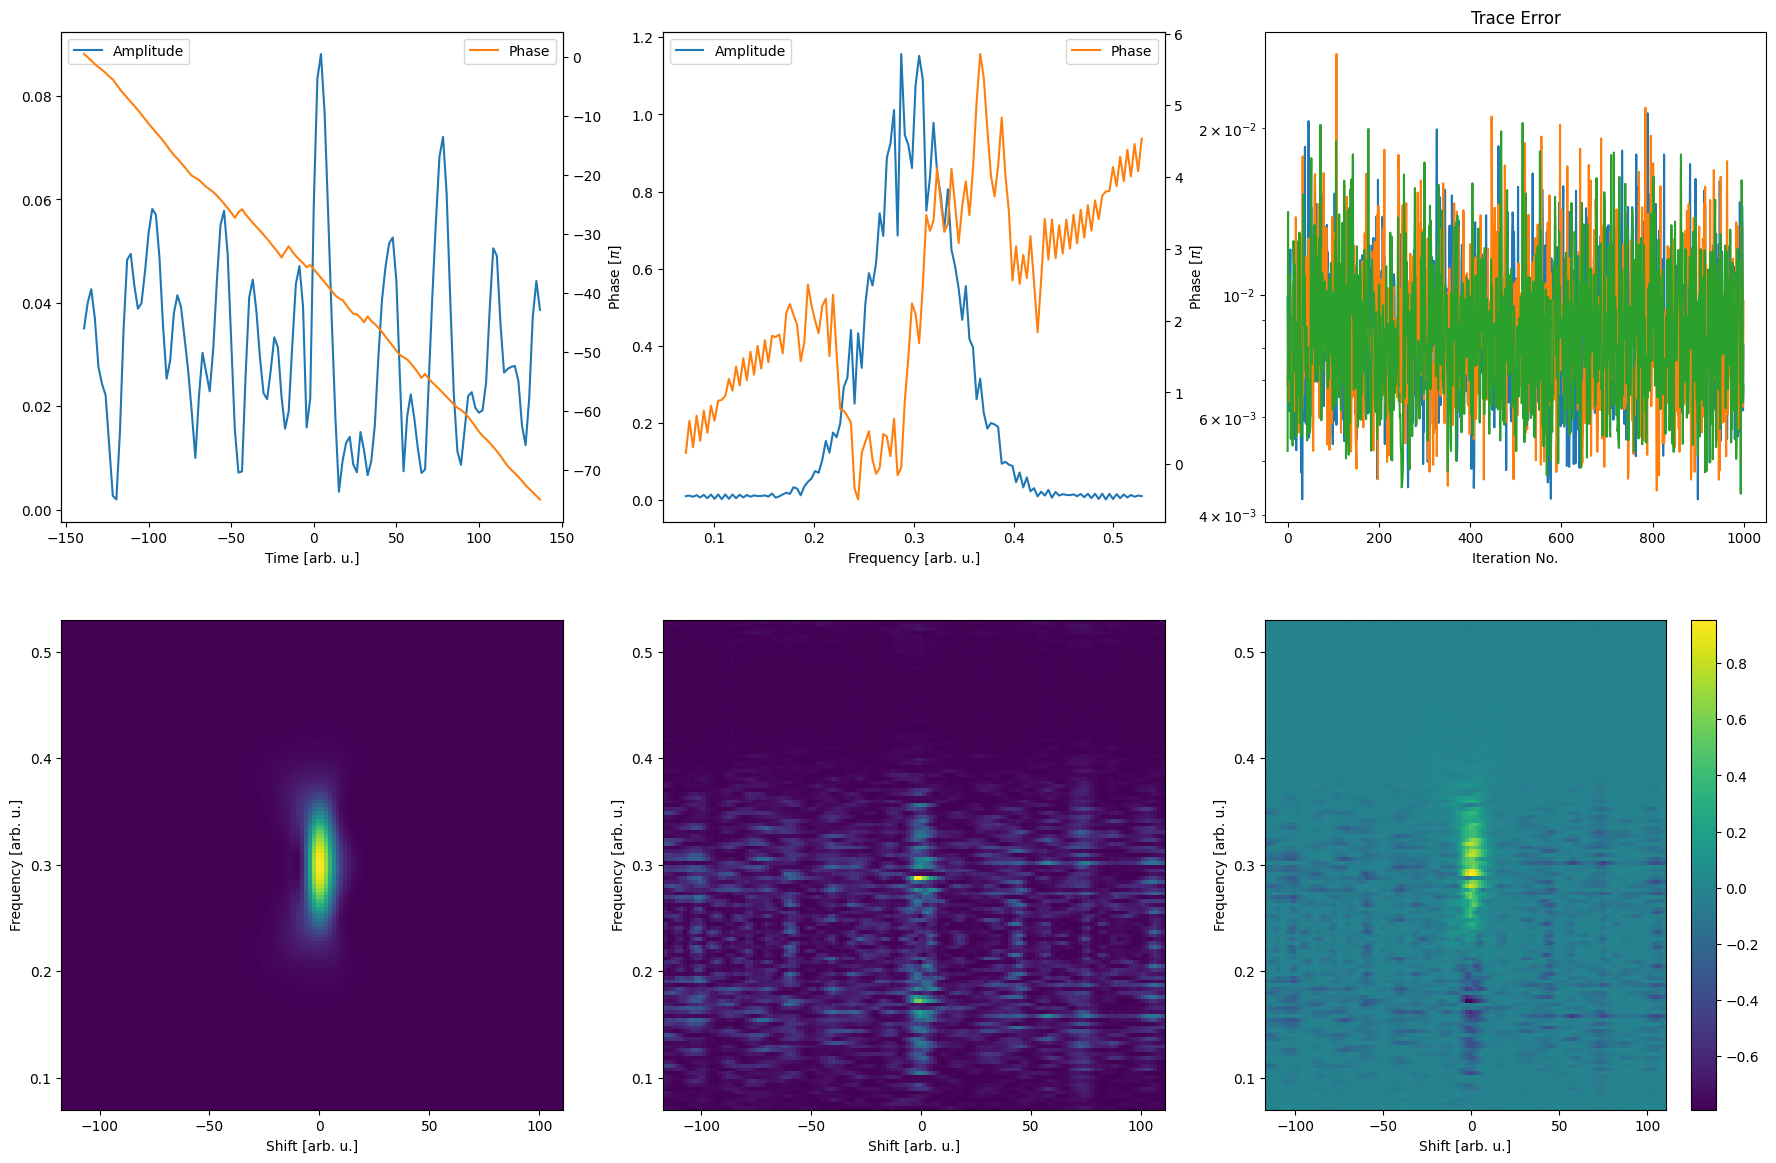

In [5]:
# de = DifferentialEvolution(time, frequency, trace, "pg", xfrog="doubleblind").use_measured_spectrum()
# spectral_amplitude = de.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = de.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = de.create_initial_population(population_size=250, amp_type="splines", phase_type="splines")

# de.strategy="best1_smooth"

# final_result = de.run(population, 150)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(time, frequency, trace, "pg", xfrog="doubleblind").use_measured_spectrum()
# spectral_amplitude = evo.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = evo.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = evo.create_initial_population(population_size=250)

# evo.solver = CMA_ES

# final_result = evo.run(population, 250)
# evo.plot_results(final_result)




lsf = LSF(time, frequency, trace, "pg", xfrog=False).use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")

population = lsf.create_initial_population(population_size=3, amp_type="discrete", phase_type="discrete")

lsf.number_of_bisection_iterations=12
lsf.random_direction_mode="random"
lsf.no_points_for_continuous=5

final_result = lsf.run(population, 1000)
lsf.plot_results(final_result)





# ad = AutoDiff(time, frequency, trace, "thg", xfrog="doubleblind").use_measured_spectrum()

# spectral_amplitude = ad.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = ad.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.alternating_optimization = True
# ad.solver = optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)

In [8]:
error_arr = jnp.copy(final_result.error_arr)

In [12]:
error_arr_rand_phase = jnp.copy(final_result.error_arr)

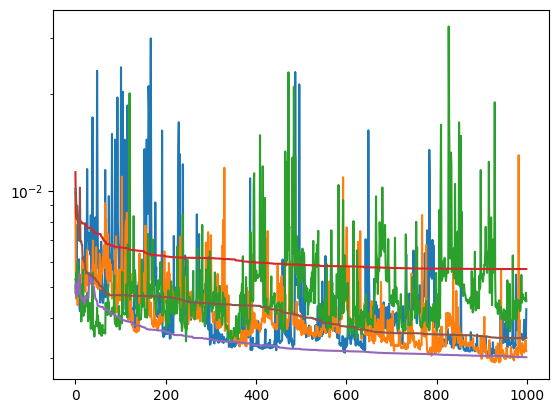

In [14]:
plt.plot(error_arr)
plt.plot(final_result.error_arr)
plt.yscale("log")

In [ ]:
from general_algorithms_dscan import DifferentialEvolution, Evosax, LSF, AutoGrad

In [ ]:
# de = DifferentialEvolution(z_arr, frequency, trace, "shg")
# population = de.create_initial_population(population_size=150)

# final_result = de.run(population, 100)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(z_arr, frequency, trace, "shg")
# evo.solver = CMA_ES
# population = evo.create_initial_population(population_size=250)

# final_result = evo.run(population, 100)
# evo.plot_results(final_result)




lsf = LSF(z_arr, frequency, trace, "shg")
population = lsf.create_initial_population(population_size=3, amp_type="random", phase_type="random")

lsf.number_of_bisection_iterations=8
lsf.random_direction_mode="random"
lsf.no_points_for_continuous=15

final_result = lsf.run(population, 2000)
lsf.plot_results(final_result)





# ad = AutoGrad(z_arr, frequency, trace, "shg")
# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.solver=optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)